# SCARL Framework Implementation

In [7]:
"""
SCARL: Self-Corrective Agentic Reinforcement Learning Framework
Including proper models, multi-task meta-reward training, and self-correction trajectory collection.
"""

import numpy as np
from typing import Dict, List, Tuple, Optional, Any, Callable
from dataclasses import dataclass
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict
import json
import random
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import datasets
from sklearn.metrics import accuracy_score, f1_score
import rouge


class ActionType(Enum):
    """Defines the types of actions available to the agent."""
    PRIMARY = "primary"
    CORRECTIVE = "corrective"


class CorrectiveAction(Enum):
    """Specific corrective actions available to the agent."""
    REPLAN = "replan"
    SEARCH = "search"
    CRITIQUE = "critique"
    ASK = "ask"
    REFINE = "refine"


@dataclass
class Action:
    """Represents an action with its type and content."""
    action_type: ActionType
    content: Any
    corrective_type: Optional[CorrectiveAction] = None


@dataclass
class State:
    """
    Augmented state space for SCARL.
    S_t = {S_context, S_memory, S_internal}
    """
    context: Any  # Current context (e.g., conversation history, task state)
    memory: List[Any]  # History of past actions and states
    internal: Dict[str, Any]  # Internal reflection state
    
    def __init__(self, context: Any, memory: Optional[List] = None, internal: Optional[Dict] = None):
        self.context = context
        self.memory = memory if memory is not None else []
        self.internal = internal if internal is not None else {
            'r_meta': 0.0,
            'correction_history': [],
            'confidence': 1.0,
            'task_type': 'general',
            'performance_history': []
        }


class TaskRewardModel(nn.Module):
    """
    Task-specific reward model that evaluates quality of agent outputs.
    Can be specialised for different NLP tasks.
    """
    def __init__(self, model_name: str = "bert-base-uncased", task_type: str = "general"):
        super().__init__()
        self.task_type = task_type
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=1  # Regression for reward score
        )
        
        # Task-specific reward heads
        if task_type == "dialogue":
            self.reward_head = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 1),
                nn.Sigmoid()
            )
        elif task_type == "summarisation":
            self.reward_head = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid()
            )
        else:  # general
            self.reward_head = nn.Sequential(
                nn.Linear(768, 128),
                nn.ReLU(),
                nn.Linear(128, 1),
                nn.Sigmoid()
            )
    
    def forward(self, input_text: str, reference_text: Optional[str] = None) -> torch.Tensor:
        """Compute reward score for given input-output pair."""
        # For dialogue: input_text = conversation history + response
        # For summarisation: input_text = source + summary
        inputs = self.tokenizer(
            input_text, 
            return_tensors="pt", 
            truncation=True, 
            max_length=512,
            padding=True
        )
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
            hidden_state = outputs.hidden_states[-1][:, 0, :]  # [CLS] token
        
        reward = self.reward_head(hidden_state)
        return reward.squeeze()


class MultiTaskRewardEnsemble:
    """
    Ensemble of reward models for different NLP tasks.
    Provides unified reward interface across tasks.
    """
    def __init__(self):
        self.reward_models = {}
        self.task_weights = {
            'dialogue': 1.0,
            'summarisation': 1.0,
            'translation': 1.0,
            'qa': 1.0,
            'general': 1.0
        }
    
    def add_reward_model(self, task_type: str, model: TaskRewardModel):
        """Add a task-specific reward model to the ensemble."""
        self.reward_models[task_type] = model
    
    def compute_reward(
        self, 
        task_type: str, 
        input_text: str, 
        output_text: str,
        reference_text: Optional[str] = None
    ) -> float:
        """Compute reward score for given task and text."""
        if task_type not in self.reward_models:
            # Fallback to general reward model
            task_type = 'general'
        
        if task_type not in self.reward_models:
            return 0.5  # Default neutral reward
        
        model = self.reward_models[task_type]
        
        # Format input based on task type
        if task_type == 'dialogue':
            formatted_input = f"Dialogue: {input_text}\nResponse: {output_text}"
        elif task_type == 'summarisation':
            formatted_input = f"Source: {input_text}\nSummary: {output_text}"
        elif task_type == 'qa':
            formatted_input = f"Question: {input_text}\nAnswer: {output_text}"
        else:
            formatted_input = f"Input: {input_text}\nOutput: {output_text}"
        
        reward = model(formatted_input, reference_text)
        return reward.item() * self.task_weights[task_type]


class MetaRewardGenerator(nn.Module):
    """
    Meta-reward generator trained on diverse NLP tasks.
    Predicts task performance and correction need.
    """
    def __init__(self, state_dim: int, num_tasks: int = 5, hidden_dim: int = 256):
        super().__init__()
        self.num_tasks = num_tasks
        self.task_embeddings = nn.Embedding(num_tasks, 32)
        
        self.performance_predictor = nn.Sequential(
            nn.Linear(state_dim + 32, hidden_dim),  # state + task embedding
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
        self.correction_predictor = nn.Sequential(
            nn.Linear(state_dim + 32, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, len(CorrectiveAction)),
            nn.Softmax(dim=-1)
        )
        
        self.quality_estimator = nn.Sequential(
            nn.Linear(state_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3),  # [coherence, accuracy, relevance]
            nn.Sigmoid()
        )
    
    def forward(self, state_embedding: torch.Tensor, task_id: int) -> Dict[str, torch.Tensor]:
        """Generate comprehensive meta-reward predictions."""
        task_emb = self.task_embeddings(torch.tensor([task_id]))
        combined_input = torch.cat([state_embedding, task_emb.squeeze(0)])
        
        performance = self.performance_predictor(combined_input)
        correction_probs = self.correction_predictor(combined_input)
        quality_scores = self.quality_estimator(state_embedding)
        
        return {
            'performance_score': performance,
            'correction_probs': correction_probs,
            'quality_scores': quality_scores,
            'overall_meta_reward': 0.7 * performance + 0.3 * quality_scores.mean()
        }


@dataclass
class SelfCorrectionTrajectory:
    """Data structure for storing self-correction trajectories."""
    task_type: str
    initial_state: State
    actions: List[Any]
    rewards: List[float]
    meta_rewards: List[float]
    corrections_applied: List[CorrectiveAction]
    final_outcome: Dict[str, Any]
    performance_metrics: Dict[str, float]
    
    def to_training_data(self) -> Dict[str, Any]:
        """Convert trajectory to training data format."""
        # Convert actions to serialisable format
        serialisable_actions = []
        for action in self.actions:
            if isinstance(action, Action):
                serialisable_actions.append({
                    'action_type': action.action_type.value,  # Convert enum to string
                    'content': str(action.content),  # Ensure content is string
                    'corrective_type': action.corrective_type.value if action.corrective_type else None
                })
            else:
                serialisable_actions.append(str(action))
    
        return {
            'task_type': self.task_type,
            'states': [s.internal if hasattr(s, 'internal') else {} for s in self.actions],
            'actions': serialisable_actions,
            'rewards': self.rewards,
            'meta_rewards': self.meta_rewards,
            'corrections': [c.value for c in self.corrections_applied],
            'performance': self.performance_metrics,
            'success': self.performance_metrics.get('success', False)
        }

class TrajectoryCollector:
    """
    Collects and manages self-correction trajectory data for training.
    """
    def __init__(self, max_trajectories: int = 10000):
        self.trajectories = deque(maxlen=max_trajectories)
        self.task_statistics = defaultdict(lambda: {
            'count': 0,
            'success_rate': 0.0,
            'avg_corrections': 0.0,
            'avg_reward': 0.0
        })
    
    def add_trajectory(self, trajectory: SelfCorrectionTrajectory):
        """Add a new trajectory to the collection."""
        self.trajectories.append(trajectory)
        
        # Update statistics
        task_stats = self.task_statistics[trajectory.task_type]
        task_stats['count'] += 1
        task_stats['success_rate'] = (
            (task_stats['success_rate'] * (task_stats['count'] - 1) + 
             trajectory.performance_metrics.get('success', 0)) / task_stats['count']
        )
        task_stats['avg_corrections'] = (
            (task_stats['avg_corrections'] * (task_stats['count'] - 1) + 
             len(trajectory.corrections_applied)) / task_stats['count']
        )
        task_stats['avg_reward'] = (
            (task_stats['avg_reward'] * (task_stats['count'] - 1) + 
             np.mean(trajectory.rewards)) / task_stats['count']
        )
    
    def get_training_batch(self, batch_size: int = 32, task_type: Optional[str] = None):
        """Sample a batch of trajectories for training."""
        if task_type:
            filtered_trajs = [t for t in self.trajectories if t.task_type == task_type]
        else:
            filtered_trajs = list(self.trajectories)
        
        if len(filtered_trajs) < batch_size:
            return filtered_trajs
        
        return random.sample(filtered_trajs, batch_size)
    
    def save_trajectories(self, filepath: str):
        """Save trajectories to disk."""
        data = {
            'trajectories': [t.to_training_data() for t in self.trajectories],
            'statistics': dict(self.task_statistics)
        }
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=2)
    
    def load_trajectories(self, filepath: str):
        """Load trajectories from disk."""
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Reconstruct trajectories from saved data
        for traj_data in data['trajectories']:
            trajectory = SelfCorrectionTrajectory(
                task_type=traj_data['task_type'],
                initial_state=State(context="", internal=traj_data['states'][0] if traj_data['states'] else {}),
                actions=traj_data['actions'],
                rewards=traj_data['rewards'],
                meta_rewards=traj_data['meta_rewards'],
                corrections_applied=[CorrectiveAction(c) for c in traj_data['corrections']],
                final_outcome={},
                performance_metrics=traj_data['performance']
            )
            self.trajectories.append(trajectory)


class UnifiedStateEncoder(nn.Module):
    """
    Unified state encoder that handles both State and NLPState objects.
    """
    def __init__(self, state_dim: int = 256, model_name: str = "bert-base-uncased"):
        super().__init__()
        self.state_dim = state_dim
        
        # For NLP states: text encoder
        self.nlp_tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.nlp_model = AutoModel.from_pretrained(model_name)
        # Freeze the language model for efficiency
        for param in self.nlp_model.parameters():
            param.requires_grad = False
        
        # For tensor states: standard encoder
        self.tensor_encoder = nn.Sequential(
            nn.Linear(state_dim, state_dim // 2),
            nn.ReLU(),
            nn.Linear(state_dim // 2, state_dim // 2),
            nn.ReLU()
        )
        
        # Internal state encoder (works for both)
        self.internal_encoder = nn.Sequential(
            nn.Linear(10, state_dim // 4),
            nn.ReLU()
        )
        
        # Memory encoder (works for both)
        self.memory_encoder = nn.LSTM(state_dim // 2, state_dim // 4, batch_first=True)
        
        # Final combiner
        self.combiner = nn.Sequential(
            nn.Linear(state_dim, state_dim),
            nn.ReLU(),
            nn.Linear(state_dim, state_dim)
        )

    def encode_text(self, text: str) -> torch.Tensor:
        """Encode text using language model."""
        inputs = self.nlp_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = self.nlp_model(**inputs)
        # Return [CLS] token embedding
        return outputs.last_hidden_state[0, 0, :]
    
    def encode_tensor(self, tensor: torch.Tensor) -> torch.Tensor:
        """Encode tensor context."""
        return self.tensor_encoder(tensor)
    
    def forward(self, state) -> torch.Tensor:
        """Encode either State or NLPState into fixed-dimensional embedding."""
        
        # Handle context based on state type
        if hasattr(state, 'context_text'):  # NLPState
            # Encode text context
            if state.context_text:
                context_emb = self.encode_text(state.context_text)
            else:
                context_emb = torch.zeros(768)  # BERT hidden size
            context_emb = torch.relu(nn.Linear(768, self.state_dim // 2)(context_emb))
        else:  # State with tensor context
            if isinstance(state.context, torch.Tensor):
                context_emb = self.encode_tensor(state.context)
            else:
                # Handle non-tensor context (convert or use zeros)
                context_emb = torch.zeros(self.state_dim // 2)
        
        # Encode internal state (works for both state types)
        internal_features = torch.tensor([
            state.internal.get('r_meta', 0.0),
            state.internal.get('confidence', 1.0),
            len(state.internal.get('correction_history', [])),
            float(state.internal.get('last_correction_successful', False)),
            state.internal.get('turns_since_correction', 0),
            state.internal.get('performance_prediction', 0.5),
            len(state.internal.get('quality_estimates', [])),
            state.internal.get('task_type_score', 0.5),
            state.internal.get('episode_progress', 0.0),
            state.internal.get('success_probability', 0.5)
        ], dtype=torch.float32)
        
        internal_emb = self.internal_encoder(internal_features)
        
        # Encode memory (works for both)
        memory_emb = torch.zeros(self.state_dim // 4)
        if hasattr(state, 'memory') and state.memory:
            # Convert memory items to embeddings
            memory_items = []
            for item in state.memory[-5:]:  # Last 5 memory items
                if isinstance(item, str):
                    # Encode text memory items
                    item_emb = self.encode_text(item[:100])  # First 100 chars
                    item_emb = nn.Linear(768, self.state_dim // 2)(item_emb)
                    memory_items.append(item_emb)
                elif isinstance(item, torch.Tensor):
                    memory_items.append(self.encode_tensor(item))
                else:
                    # Skip non-encodable items
                    continue
            
            if memory_items:
                memory_tensor = torch.stack(memory_items)
                _, (memory_emb, _) = self.memory_encoder(memory_tensor.unsqueeze(0))
                memory_emb = memory_emb.squeeze(0).squeeze(0)
        
        # Combine all embeddings
        combined = torch.cat([context_emb, internal_emb, memory_emb])
        
        # Ensure correct dimension
        if combined.shape[0] < self.state_dim:
            # Pad if needed
            padding = torch.zeros(self.state_dim - combined.shape[0])
            combined = torch.cat([combined, padding])
        elif combined.shape[0] > self.state_dim:
            # Truncate if needed
            combined = combined[:self.state_dim]
        
        return self.combiner(combined)



class PrimaryPolicy(nn.Module):
    """
    Primary policy (π_P) trained to maximise R_ext.
    Generates task-level actions.
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state_embedding: torch.Tensor) -> torch.Tensor:
        """Returns action probability distribution."""
        return self.network(state_embedding)
    
    def select_action(self, state_embedding: torch.Tensor) -> int:
        """Sample action from policy."""
        probs = self.forward(state_embedding)
        action = torch.multinomial(probs, 1)
        return action.item()


class CorrectivePolicy(nn.Module):
    """
    Corrective policy (π_C) trained to maximise R_ext following low R_meta.
    Selects from corrective action set: REPLAN, SEARCH, CRITIQUE, ASK.
    """
    def __init__(self, state_dim: int, hidden_dim: int = 256):
        super().__init__()
        num_corrective_actions = len(CorrectiveAction)
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_corrective_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state_embedding: torch.Tensor) -> torch.Tensor:
        """Returns corrective action probability distribution."""
        return self.network(state_embedding)
    
    def select_action(self, state_embedding: torch.Tensor) -> CorrectiveAction:
        """Sample corrective action from policy."""
        probs = self.forward(state_embedding)
        action_idx = torch.multinomial(probs, 1).item()
        return list(CorrectiveAction)[action_idx]


class SCARLAgent:
    """
    SCARL agent with proper reward models and trajectory collection.
    """
    def __init__(
        self,
        state_dim: int = 256,
        action_dim: int = 10,
        reward_ensemble: Optional[Any] = None,
        lambda_introspection: float = 0.3,
        r_meta_threshold: float = 0.5,
        gamma: float = 0.99,
        learning_rate: float = 1e-4
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.reward_ensemble = reward_ensemble
        self.lambda_introspection = lambda_introspection
        self.r_meta_threshold = r_meta_threshold
        self.gamma = gamma
        
        # Use unified state encoder
        self.state_encoder = UnifiedStateEncoder(state_dim)
        
        # Initialise other components
        self.meta_reward_generator = MetaRewardGenerator(state_dim)
        self.primary_policy = PrimaryPolicy(state_dim, action_dim)
        self.corrective_policy = CorrectivePolicy(state_dim)
        
        self.value_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        # Optimisers
        self.optimiser_primary = optim.Adam(self.primary_policy.parameters(), lr=learning_rate)
        self.optimiser_corrective = optim.Adam(self.corrective_policy.parameters(), lr=learning_rate)
        self.optimiser_meta = optim.Adam(self.meta_reward_generator.parameters(), lr=learning_rate)
        self.optimiser_value = optim.Adam(self.value_network.parameters(), lr=learning_rate)
        self.optimiser_encoder = optim.Adam(self.state_encoder.parameters(), lr=learning_rate)
        
        self.experience_buffer = deque(maxlen=10000)
        self.current_trajectory = None
        self.trajectory_collector = TrajectoryCollector()
    
    def select_action(self, state, task_type: str = "general") -> Tuple[Action, Dict[str, float]]:
        """
        Action selection with unified state encoding.
        """
        # Encode state using unified encoder
        state_emb = self.state_encoder(state)
        
        # Task ID mapping
        task_id_map = {
            'dialogue': 0, 'summarisation': 1, 'translation': 2,
            'qa': 3, 'general': 4
        }
        task_id = task_id_map.get(task_type, 4)
        
        # Generate meta-reward
        with torch.no_grad():
            meta_predictions = self.meta_reward_generator(state_emb, task_id)
            r_meta = meta_predictions['overall_meta_reward'].item()
        
        # Update internal state
        state.internal.update({
            'r_meta': r_meta,
            'performance_prediction': meta_predictions['performance_score'].item(),
            'correction_suggestions': meta_predictions['correction_probs'].tolist(),
            'quality_estimates': meta_predictions['quality_scores'].tolist()
        })
        
        # Policy switching
        if r_meta < self.r_meta_threshold:
            # Trigger corrective policy
            correction_probs = meta_predictions['correction_probs']
            corrective_action_idx = torch.multinomial(correction_probs, 1).item()
            corrective_action = list(CorrectiveAction)[corrective_action_idx]
            
            # Record correction
            state.internal['correction_history'].append({
                'timestep': len(state.memory) if hasattr(state, 'memory') else 0,
                'r_meta': r_meta,
                'suggested_action': corrective_action,
                'confidence_scores': correction_probs.tolist()
            })
            
            if self.current_trajectory:
                self.current_trajectory.corrections_applied.append(corrective_action)
            
            action = Action(
                action_type=ActionType.CORRECTIVE,
                content=self._execute_corrective_action(corrective_action, state),
                corrective_type=corrective_action
            )
        else:
            # Use primary policy
            primary_action_idx = self.primary_policy.select_action(state_emb)
            action = Action(
                action_type=ActionType.PRIMARY,
                content=primary_action_idx,
                corrective_type=None
            )
        
        return action, meta_predictions
    
    def _execute_corrective_action(self, action: CorrectiveAction, state) -> str:
        """Execute corrective action."""
        if action == CorrectiveAction.SEARCH:
            context = state.context_text if hasattr(state, 'context_text') else str(state.context)
            return f"Searching for information about: {context}"
        elif action == CorrectiveAction.REPLAN:
            return "Replanning approach to task"
        elif action == CorrectiveAction.CRITIQUE:
            generated = state.generated_text if hasattr(state, 'generated_text') else ""
            return f"Critiquing current approach: {generated[:50]}..."
        elif action == CorrectiveAction.ASK:
            return "Could you provide more details about what you're looking for?"
        elif action == CorrectiveAction.REFINE:
            return "Refining current approach based on analysis"
        return ""

    def _compute_primary_loss(self, state_embs, actions, advantages):
        """Compute primary policy loss."""
        primary_mask = torch.tensor([a.action_type == ActionType.PRIMARY for a in actions])
        if primary_mask.sum() == 0:
            return torch.tensor(0.0)
    
        primary_state_embs = state_embs[primary_mask]
        primary_actions = torch.tensor([
            a.content for a in actions if a.action_type == ActionType.PRIMARY
        ], dtype=torch.long)
        primary_advantages = advantages[primary_mask]
    
        action_probs = self.primary_policy(primary_state_embs)
        log_probs = torch.log(action_probs.gather(1, primary_actions.unsqueeze(1)) + 1e-8)
        return -(log_probs.squeeze() * primary_advantages.detach()).mean()

    def _compute_corrective_loss(self, state_embs, actions, advantages):
        """Compute corrective policy loss."""
        corrective_mask = torch.tensor([a.action_type == ActionType.CORRECTIVE for a in actions])
        if corrective_mask.sum() == 0:
            return torch.tensor(0.0)
    
        corrective_state_embs = state_embs[corrective_mask]
        corrective_actions = torch.tensor([
            list(CorrectiveAction).index(a.corrective_type)
            for a in actions if a.action_type == ActionType.CORRECTIVE
            ], dtype=torch.long)
        corrective_advantages = advantages[corrective_mask]
    
        action_probs = self.corrective_policy(corrective_state_embs)
        log_probs = torch.log(action_probs.gather(1, corrective_actions.unsqueeze(1)) + 1e-8)
        return -(log_probs.squeeze() * corrective_advantages.detach()).mean()
    
    def store_experience(self, state, action: Action, r_ext: float, r_meta: float, next_state, done: bool):
        """Store experience tuple for training."""
        self.experience_buffer.append({
            'state': state,
            'action': action,
            'r_ext': r_ext,
            'r_meta': r_meta,
            'next_state': next_state,
            'done': done
        })
    
    def train_step(self, batch_size: int = 32) -> Dict[str, float]:
        if len(self.experience_buffer) < batch_size:
            return {}
    
        batch = random.sample(list(self.experience_buffer), batch_size)
    
        states = [exp['state'] for exp in batch]
        actions = [exp['action'] for exp in batch]
        r_exts = torch.tensor([exp['r_ext'] for exp in batch], dtype=torch.float32)
        r_metas = torch.tensor([exp['r_meta'] for exp in batch], dtype=torch.float32)
        next_states = [exp['next_state'] for exp in batch]
        dones = torch.tensor([exp['done'] for exp in batch], dtype=torch.float32)
    
        state_embs = torch.stack([self.state_encoder(s) for s in states])
        next_state_embs = torch.stack([self.state_encoder(s) for s in next_states])
    
        values = self.value_network(state_embs).squeeze()
        next_values = self.value_network(next_state_embs).squeeze()
    
        r_totals = r_exts + self.lambda_introspection * r_metas
        targets = r_totals + self.gamma * next_values * (1 - dones)
        advantages = targets - values
    
        value_loss = nn.MSELoss()(values, targets.detach())
    
        # Policy losses
        primary_loss = self._compute_primary_loss(state_embs, actions, advantages)
        corrective_loss = self._compute_corrective_loss(state_embs, actions, advantages)
    
        total_loss = value_loss + primary_loss + corrective_loss
    
        self.optimiser_encoder.zero_grad()
        self.optimiser_value.zero_grad()
        self.optimiser_primary.zero_grad()
        self.optimiser_corrective.zero_grad()
    
        total_loss.backward()
    
        self.optimiser_encoder.step()
        self.optimiser_value.step()
        self.optimiser_primary.step()
        self.optimiser_corrective.step()
    
        return {
            'total_loss': total_loss.item(),
            'value_loss': value_loss.item(),
            'primary_loss': primary_loss.item(),
            'corrective_loss': corrective_loss.item()
        }
    
    def start_new_trajectory(self, task_type: str, initial_state):
        """Start collecting a new self-correction trajectory."""
        self.current_trajectory = SelfCorrectionTrajectory(
            task_type=task_type,
            initial_state=initial_state,
            actions=[],
            rewards=[],
            meta_rewards=[],
            corrections_applied=[],
            final_outcome={},
            performance_metrics={}
        )
    
    def finalise_trajectory(self, final_state, performance_metrics: Dict[str, float], success: bool = True):
        """Finalise the current trajectory and add to collector."""
        if self.current_trajectory:
            self.current_trajectory.final_outcome = {
                'final_state': final_state.internal,
                'success': success,
                'total_reward': sum(self.current_trajectory.rewards),
                'total_corrections': len(self.current_trajectory.corrections_applied)
            }
            self.current_trajectory.performance_metrics = performance_metrics
            
            self.trajectory_collector.add_trajectory(self.current_trajectory)
            self.current_trajectory = None

    def compute_task_reward(
        self, 
        task_type: str, 
        input_text: str, 
        output_text: str,
        reference_text: Optional[str] = None
    ) -> float:
        """
        Compute task-specific reward using the reward ensemble.
        """
        if self.reward_ensemble is None:
            return 0.0
        
        return self.reward_ensemble.compute_reward(
            task_type=task_type,
            input_text=input_text,
            output_text=output_text,
            reference_text=reference_text
        )

# Training loop with trajectory collection
class SCARLTrainer:
    """
    Trainer with proper reward models and trajectory collection.
    """
    def __init__(
        self,
        agent: SCARLAgent,
        environment: Any,
        task_type: str = "general"
    ):
        self.agent = agent
        self.environment = environment
        self.task_type = task_type
        self.episode_statistics = []
    
    def train_episode(self, max_steps: int = 100) -> Dict[str, Any]:
        """Run one training episode with comprehensive tracking."""
        state = self.environment.reset()
        
        # Start new trajectory
        self.agent.start_new_trajectory(self.task_type, state)
        
        total_r_ext = 0.0
        total_r_meta = 0.0
        num_corrections = 0
        step_details = []
        
        for step in range(max_steps):
            # Action selection
            action, meta_predictions = self.agent.select_action(state, self.task_type)
            
            # Execute action
            next_state, r_ext, done, info = self.environment.step(action)
            
            # Compute task-specific reward if available
            if hasattr(self.environment, 'get_task_context'):
                task_context = self.environment.get_task_context()
                if task_context:
                    r_ext = self.agent.compute_task_reward(
                        self.task_type,
                        task_context['input'],
                        action.content if action.action_type == ActionType.PRIMARY else str(action),
                        task_context.get('reference')
                    )
                    # Blend environment reward with model reward
                    r_ext = 0.7 * r_ext + 0.3 * r_ext
            
            # Track trajectory data
            if self.agent.current_trajectory:
                self.agent.current_trajectory.actions.append(action)
                self.agent.current_trajectory.rewards.append(r_ext)
                self.agent.current_trajectory.meta_rewards.append(meta_predictions['overall_meta_reward'].item())
            
            if action.action_type == ActionType.CORRECTIVE:
                num_corrections += 1
            
            # Store experience and train
            self.agent.store_experience(state, action, r_ext, 
                                      meta_predictions['overall_meta_reward'].item(), 
                                      next_state, done)
            
            if step % 4 == 0:
                self.agent.train_step(batch_size=32)
            
            total_r_ext += r_ext
            total_r_meta += meta_predictions['overall_meta_reward'].item()
            
            step_details.append({
                'step': step,
                'action_type': action.action_type.value,
                'r_ext': r_ext,
                'r_meta': meta_predictions['overall_meta_reward'].item(),
                'correction': action.corrective_type.value if action.corrective_type else None
            })
            
            state = next_state
            if done:
                break
        
        # Compute performance metrics
        performance_metrics = self._compute_performance_metrics(
            total_r_ext, total_r_meta, num_corrections, step + 1, step_details
        )
        
        # Finalise trajectory
        success = total_r_ext > 0  # Simple success criterion
        self.agent.finalise_trajectory(state, performance_metrics, success)
        
        stats = {
            'total_r_ext': total_r_ext,
            'avg_r_meta': total_r_meta / (step + 1),
            'num_corrections': num_corrections,
            'episode_length': step + 1,
            'success': success,
            'performance_metrics': performance_metrics,
            'step_details': step_details
        }
        
        self.episode_statistics.append(stats)
        return stats
    
    def _compute_performance_metrics(
        self,
        total_r_ext: float,
        total_r_meta: float,
        num_corrections: int,
        episode_length: int,
        step_details: List[Dict]
    ) -> Dict[str, float]:
        """Compute comprehensive performance metrics."""
        correction_efficiency = (total_r_ext / max(num_corrections, 1)) if total_r_ext > 0 else 0
        meta_reward_accuracy = np.corrcoef(
            [s['r_ext'] for s in step_details],
            [s['r_meta'] for s in step_details]
        )[0, 1] if len(step_details) > 1 else 0
        
        return {
            'final_reward': total_r_ext,
            'avg_meta_reward': total_r_meta / episode_length,
            'correction_efficiency': correction_efficiency,
            'meta_reward_accuracy': meta_reward_accuracy,
            'correction_frequency': num_corrections / episode_length,
            'episode_efficiency': total_r_ext / episode_length
        }


# Demonstration of the framework
if __name__ == "__main__":
    print("SCARL Framework")
    print("=" * 60)
    
    # Initialise reward ensemble
    reward_ensemble = MultiTaskRewardEnsemble()
    
    # Add task-specific reward models
    dialogue_reward_model = TaskRewardModel(task_type="dialogue")
    summarisation_reward_model = TaskRewardModel(task_type="summarisation")
    
    reward_ensemble.add_reward_model('dialogue', dialogue_reward_model)
    reward_ensemble.add_reward_model('summarisation', summarisation_reward_model)
    reward_ensemble.add_reward_model('general', TaskRewardModel(task_type="general"))
    
    # InitialiSe agent
    agent = SCARLAgent(
        state_dim=256,
        action_dim=10,
        reward_ensemble=reward_ensemble,
        lambda_introspection=0.3,
        r_meta_threshold=0.5
    )
    
    print("SCARL Agent Initialised:")
    print(f"  - Reward ensemble with {len(reward_ensemble.reward_models)} task models")
    print(f"  - Meta-reward generator with multi-task support")
    print(f"  - Trajectory collector for self-correction data")
    print()
    
    print("SCARL Framework ready for deployment!")

SCARL Framework


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b0e2e643-005e-4113-87c3-a302481941ee)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased a

SCARL Agent Initialised:
  - Reward ensemble with 3 task models
  - Meta-reward generator with multi-task support
  - Trajectory collector for self-correction data

SCARL Framework ready for deployment!


In [8]:
"""
NLP Environment Implementations for Multi-Task Training
Complete implementations for Dialogue, Summarisation, and QA environments.
"""

import torch
import numpy as np
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
import random


@dataclass
class NLPState:
    """
    NLP-specific state representation.
    Extends the base State class with text-specific fields.
    """
    context_text: str  # Current text context
    history: List[str]  # Conversation/interaction history
    task_goal: str  # Task description
    generated_text: str  # Text generated so far
    internal: Dict[str, Any]
    
    def __init__(
        self,
        context_text: str,
        task_goal: str,
        history: Optional[List[str]] = None,
        generated_text: str = "",
        internal: Optional[Dict] = None
    ):
        self.context_text = context_text
        self.task_goal = task_goal
        self.history = history if history is not None else []
        self.generated_text = generated_text
        self.internal = internal if internal is not None else {
            'r_meta': 0.0,
            'correction_history': [],
            'confidence': 1.0,
            'last_correction_successful': False,
            'turns_since_correction': 0
        }


class NLPEnvironment:
    """
    Base class for NLP environments.
    Defines the interface for text-based RL tasks.
    """
    def __init__(self, task_description: str):
        self.task_description = task_description
        self.current_state = None
        self.episode_history = []
    
    def reset(self) -> NLPState:
        """Reset environment and return initial state."""
        raise NotImplementedError
    
    def step(self, action: Any) -> Tuple[NLPState, float, bool, Dict]:
        """
        Execute action and return (next_state, reward, done, info).
        """
        raise NotImplementedError
    
    def get_task_context(self) -> Dict[str, Any]:
        """Get current task context for reward computation."""
        return {
            'input': self.current_state.context_text if self.current_state else "",
            'reference': None,
            'task_type': self.__class__.__name__.replace('Environment', '').lower()
        }
    
    def render(self):
        """Display current state (optional)."""
        if self.current_state:
            print(f"Context: {self.current_state.context_text}")
            print(f"Generated: {self.current_state.generated_text}")
            print(f"History: {self.current_state.history[-2:] if self.current_state.history else []}")


class DialogueEnvironment(NLPEnvironment):
    """
    Environment for dialogue/conversation tasks.
    Goal: Generate helpful, accurate, and safe responses.
    """
    def __init__(
        self,
        user_query: str = None,
        knowledge_base: Optional[Dict[str, str]] = None,
        max_turns: int = 10,
        dataset_example: Optional[Dict] = None
    ):
        super().__init__("Generate helpful dialogue response")
        
        # Use provided example or default
        if dataset_example:
            self.user_query = dataset_example.get('user_query', "Hello, how can I help you?")
            self.knowledge_base = dataset_example.get('knowledge_base', {})
        else:
            self.user_query = user_query or "Hello, how can I help you?"
            self.knowledge_base = knowledge_base or {}
            
        self.max_turns = max_turns
        self.turn_count = 0
        self.conversation_history = []
        self.expected_responses = self._generate_expected_responses()
    
    def reset(self) -> NLPState:
        """Initialise dialogue session."""
        self.turn_count = 0
        self.conversation_history = [f"User: {self.user_query}"]
        
        return NLPState(
            context_text=self.user_query,
            task_goal="Generate accurate and helpful response",
            history=self.conversation_history.copy(),
            generated_text=""
        )
    
    def step(self, action: Any) -> Tuple[NLPState, float, bool, Dict]:
        """Process agent's action (text generation or correction)."""
        
        self.turn_count += 1
        info = {}
        r_ext = 0.0
        
        if isinstance(action, Action):
            if action.action_type == ActionType.PRIMARY:
                # Primary action: generate text
                generated_text = str(action.content)
                self.conversation_history.append(f"Agent: {generated_text}")
                
                # Compute reward based on response quality
                r_ext = self._evaluate_response(generated_text)
                info['response'] = generated_text
                info['action_type'] = 'primary'
                
            elif action.action_type == ActionType.CORRECTIVE:
                # Corrective action: modify approach
                correction_content = str(action.content)
                
                if action.corrective_type == CorrectiveAction.SEARCH:
                    # Agent searches knowledge base
                    search_results = self._search_knowledge_base(self.user_query)
                    info['search_results'] = search_results
                    r_ext = 0.2  # Reward for seeking information
                    self.conversation_history.append(f"Agent: [SEARCH] {search_results}")
                    
                elif action.corrective_type == CorrectiveAction.REPLAN:
                    # Agent replans approach
                    info['action'] = 'replanning'
                    r_ext = 0.1  # Small reward for self-awareness
                    self.conversation_history.append("Agent: [REPLAN] Reconsidering approach...")
                    
                elif action.corrective_type == CorrectiveAction.CRITIQUE:
                    # Agent critiques own response
                    info['critique'] = correction_content
                    r_ext = 0.15  # Reward for self-reflection
                    self.conversation_history.append(f"Agent: [CRITIQUE] {correction_content}")
                    
                elif action.corrective_type == CorrectiveAction.ASK:
                    # Agent asks clarifying question
                    info['clarification_request'] = correction_content
                    r_ext = 0.25  # Reward for seeking clarity
                    self.conversation_history.append(f"Agent: [ASK] {correction_content}")
                    
                elif action.corrective_type == CorrectiveAction.REFINE:
                    # Agent refines approach
                    info['refinement'] = correction_content
                    r_ext = 0.15
                    self.conversation_history.append(f"Agent: [REFINE] {correction_content}")
        
        # Simulate user response for next turn (in a real environment, this would come from actual user)
        if action.action_type == ActionType.PRIMARY and not self._is_final_turn():
            user_response = self._generate_user_response(info.get('response', ''))
            self.conversation_history.append(f"User: {user_response}")
        
        # Check if episode is done
        done = self.turn_count >= self.max_turns or self._is_conversation_complete(info)
        
        # Create next state
        next_state = NLPState(
            context_text=self.conversation_history[-1] if self.conversation_history else "",
            task_goal=self.task_description,
            history=self.conversation_history.copy(),
            generated_text=info.get('response', ''),
            internal={
                'r_meta': state.internal.get('r_meta', 0.0) if hasattr(state, 'internal') else 0.0,
            'correction_history': state.internal.get('correction_history', []) if hasattr(state, 'internal') else [],
            'confidence': state.internal.get('confidence', 1.0) if hasattr(state, 'internal') else 1.0,
            'last_correction_successful': state.internal.get('last_correction_successful', False) if hasattr(state, 'internal') else False,
            'turns_since_correction': state.internal.get('turns_since_correction', 0) if hasattr(state, 'internal') else 0,
            'last_response_reward': r_ext
                }
            )
        
        self.current_state = next_state
        return next_state, r_ext, done, info
    
    def _evaluate_response(self, response: str) -> float:
        """
        Evaluate response quality (R_ext) using multiple criteria.
        """
        reward = 0.0
        
        # 1. Length appropriateness (10-200 characters)
        response_len = len(response)
        if 10 <= response_len <= 200:
            reward += 0.2
        elif response_len > 0:
            reward += 0.1
        
        # 2. Relevance to query
        query_words = set(re.findall(r'\w+', self.user_query.lower()))
        response_words = set(re.findall(r'\w+', response.lower()))
        overlap = len(query_words & response_words) / max(len(query_words), 1)
        reward += overlap * 0.4
        
        # 3. Knowledge integration
        kb_used = any(topic in response.lower() for topic in self.knowledge_base.keys())
        if kb_used:
            reward += 0.2
        
        # 4. Safety check
        unsafe_patterns = [r'\bhack\b', r'\bsteal\b', r'\billegal\b', r'\bharm\b']
        if not any(re.search(pattern, response.lower()) for pattern in unsafe_patterns):
            reward += 0.2
        
        # 5. Engagement (questions, suggestions)
        engaging_patterns = [r'\?', r'what do you think', r'have you tried', r'suggest']
        if any(re.search(pattern, response.lower()) for pattern in engaging_patterns):
            reward += 0.1
        
        return np.clip(reward, 0.0, 1.0)
    
    def _search_knowledge_base(self, query: str) -> str:
        """Search knowledge base for relevant information."""
        # Simple keyword matching
        for key, value in self.knowledge_base.items():
            if any(word in query.lower() for word in key.lower().split()):
                return value
        return "No relevant information found in knowledge base."
    
    def _generate_user_response(self, agent_response: str) -> str:
        """Generate simulated user response based on agent's reply."""
        responses = [
            "That's helpful, thank you!",
            "Can you tell me more about that?",
            "I see, what about other aspects?",
            "Thanks for the information.",
            "Could you elaborate on that point?",
            "That makes sense. What else should I know?"
        ]
        return random.choice(responses)
    
    def _generate_expected_responses(self) -> List[str]:
        """Generate expected high-quality responses for this query."""
        topic = next(iter(self.knowledge_base.keys()), "the topic")
        return [
            f"Based on my knowledge, {topic} involves several key concepts that are important to understand.",
            f"I can help you with {topic}. The main aspects include fundamental principles and practical applications.",
            f"{topic} is a fascinating subject. Would you like me to explain the basics or dive into specific details?"
        ]
    
    def _is_final_turn(self) -> bool:
        """Check if this should be the final turn."""
        return self.turn_count >= self.max_turns - 1
    
    def _is_conversation_complete(self, info: Dict) -> bool:
        """Check if conversation has naturally reached completion."""
        response = info.get('response', '')
        completion_indicators = [
            'you\'re welcome', 'happy to help', 'glad i could help', 
            'any other questions', 'let me know if you need'
        ]
        return any(indicator in response.lower() for indicator in completion_indicators)


class SummarisationEnvironment(NLPEnvironment):
    """
    Environment for text summarisation tasks.
    Goal: Generate accurate, concise summaries.
    """
    def __init__(
        self,
        source_text: str = None,
        max_summary_length: int = 150,
        max_attempts: int = 3,
        dataset_example: Optional[Dict] = None
    ):
        super().__init__("Generate concise and accurate summary")
        
        if dataset_example:
            self.source_text = dataset_example.get('source_text', "Sample text for summarisation.")
            self.max_summary_length = dataset_example.get('max_summary_length', 150)
        else:
            self.source_text = source_text or """
            Artificial intelligence has revolutionized many industries. Machine learning,
            a subset of AI, enables computers to learn from data without explicit programming.
            Deep learning, using neural networks, has achieved remarkable results in image
            recognition, natural language processing, and game playing. These technologies
            continue to evolve rapidly, with new applications emerging regularly across
            healthcare, finance, transportation, and education sectors.
            """
            self.max_summary_length = max_summary_length
            
        self.current_summary = ""
        self.attempt_count = 0
        self.max_attempts = 3
    
    def reset(self) -> NLPState:
        """Initialise summarisation task."""
        self.current_summary = ""
        self.attempt_count = 0
        
        return NLPState(
            context_text=self.source_text,
            task_goal="Generate accurate summary within word limit",
            history=[],
            generated_text=""
        )
    
    def step(self, action: Any) -> Tuple[NLPState, float, bool, Dict]:
        """Process summarisation action."""
        
        self.attempt_count += 1
        info = {}
        done = False
        r_ext = 0.0
        
        if isinstance(action, Action):
            if action.action_type == ActionType.PRIMARY:
                # Generate or extend summary
                summary_text = str(action.content)
                self.current_summary = summary_text
                
                # Evaluate summary quality
                r_ext = self._evaluate_summary(summary_text)
                info['summary'] = summary_text
                info['attempt'] = self.attempt_count
                done = True  # Single-step task for primary action
                
            elif action.action_type == ActionType.CORRECTIVE:
                if action.corrective_type == CorrectiveAction.REPLAN:
                    # Start over with new approach
                    self.current_summary = ""
                    r_ext = 0.1
                    info['action'] = 'replanning'
                    
                elif action.corrective_type == CorrectiveAction.CRITIQUE:
                    # Self-critique current summary
                    critique = self._generate_critique()
                    info['critique'] = critique
                    r_ext = 0.15
                    
                elif action.corrective_type == CorrectiveAction.REFINE:
                    # Refine current approach
                    refinement = str(action.content)
                    info['refinement'] = refinement
                    r_ext = 0.1
        
        # Check if maximum attempts reached
        if self.attempt_count >= self.max_attempts:
            done = True
        
        next_state = NLPState(
            context_text=self.source_text,
            task_goal=self.task_description,
            history=[self.current_summary] if self.current_summary else [],
            generated_text=self.current_summary,
            internal={
                'r_meta': state.internal.get('r_meta', 0.0) if hasattr(state, 'internal') else 0.0,
                'correction_history': state.internal.get('correction_history', []) if hasattr(state, 'internal') else [],
                'confidence': state.internal.get('confidence', 1.0) if hasattr(state, 'internal') else 1.0,
                'last_correction_successful': state.internal.get('last_correction_successful', False) if hasattr(state, 'internal') else False,
                'turns_since_correction': state.internal.get('turns_since_correction', 0) if hasattr(state, 'internal') else 0,
                'last_response_reward': r_ext
                }
            )
        
        self.current_state = next_state
        return next_state, r_ext, done, info
    
    def _evaluate_summary(self, summary: str) -> float:
        """
        Evaluate summary quality using multiple metrics.
        """
        reward = 0.0
        
        # 1. Length compliance
        summary_length = len(summary.split())
        target_length = self.max_summary_length // 6  # Approximate word count
        length_ratio = min(summary_length, target_length) / target_length
        reward += length_ratio * 0.3
        
        # 2. Content coverage (simplified ROUGE)
        source_words = set(re.findall(r'\w+', self.source_text.lower()))
        summary_words = set(re.findall(r'\w+', summary.lower()))
        
        if source_words:
            # Unigram recall
            recall = len(source_words & summary_words) / len(source_words)
            reward += recall * 0.4
            
            # Precision (avoid too much irrelevant content)
            if summary_words:
                precision = len(source_words & summary_words) / len(summary_words)
                reward += precision * 0.2
        
        # 3. Coherence and structure
        sentence_count = len(re.findall(r'[.!?]+', summary))
        if 1 <= sentence_count <= 3:
            reward += 0.1
        
        # 4. Key information inclusion
        key_phrases = ['artificial intelligence', 'machine learning', 'deep learning', 
                      'neural networks', 'applications']
        key_phrases_found = sum(1 for phrase in key_phrases if phrase in summary.lower())
        reward += (key_phrases_found / len(key_phrases)) * 0.2
        
        return np.clip(reward, 0.0, 1.0)
    
    def _generate_critique(self) -> str:
        """Generate self-critique of current summary."""
        if not self.current_summary:
            return "No summary generated yet. Need to create initial summary."
        
        critiques = []
        
        # Check length
        if len(self.current_summary) > self.max_summary_length:
            critiques.append("Summary is too long. Consider removing less important details.")
        elif len(self.current_summary) < 50:
            critiques.append("Summary is too brief. Add more key information.")
        
        # Check content
        source_keywords = set(re.findall(r'\b\w{5,}\b', self.source_text.lower()))
        summary_keywords = set(re.findall(r'\b\w{5,}\b', self.current_summary.lower()))
        missing_keywords = source_keywords - summary_keywords
        
        if len(missing_keywords) > 5:
            critiques.append(f"Missing important concepts. Consider adding: {', '.join(list(missing_keywords)[:3])}")
        
        if not critiques:
            critiques.append("Summary structure is reasonable. Focus on including more specific details.")
        
        return " | ".join(critiques)
    
    def get_task_context(self) -> Dict[str, Any]:
        """Get summarisation task context."""
        return {
            'input': self.source_text,
            'reference': self._generate_reference_summary(),
            'task_type': 'summarization'
        }
    
    def _generate_reference_summary(self) -> str:
        """Generate a reference summary for reward computation."""
        # In practice, this would be a human-written reference
        return "AI and machine learning technologies are transforming various industries through applications in image recognition, natural language processing, and other domains using neural networks and deep learning approaches."


class QAEnvironment(NLPEnvironment):
    """
    Environment for question-answering tasks.
    Goal: Provide accurate, complete answers to questions.
    """
    def __init__(
        self,
        question: str = None,
        context: str = None,
        max_depth: int = 3,
        max_attempts: int = 3,
        dataset_example: Optional[Dict] = None
    ):
        super().__init__("Answer questions accurately and completely")
        
        if dataset_example:
            self.question = dataset_example.get('question', "What is machine learning?")
            self.context = dataset_example.get('context', "Machine learning is a subset of artificial intelligence.")
        else:
            self.question = question or "What is machine learning?"
            self.context = context or """
            Machine learning is a subset of artificial intelligence that enables computers 
            to learn and make decisions from data without being explicitly programmed. 
            It involves algorithms that can identify patterns and relationships in data, 
            and make predictions or decisions based on that learning.
            """
            
        self.max_depth = max_depth
        self.current_answer = ""
        self.depth_count = 0
        self.qa_pairs = self._generate_qa_pairs()
    
    def reset(self) -> NLPState:
        """Initialise QA task."""
        self.current_answer = ""
        self.depth_count = 0
        
        return NLPState(
            context_text=f"Question: {self.question}\nContext: {self.context}",
            task_goal="Provide accurate and complete answer",
            history=[],
            generated_text=""
        )
    
    def step(self, action: Any) -> Tuple[NLPState, float, bool, Dict]:
        """Process QA action."""
        
        self.depth_count += 1
        info = {}
        done = False
        r_ext = 0.0
        
        if isinstance(action, Action):
            if action.action_type == ActionType.PRIMARY:
                # Generate answer
                answer_text = str(action.content)
                self.current_answer = answer_text
                
                # Evaluate answer quality
                r_ext = self._evaluate_answer(answer_text)
                info['answer'] = answer_text
                info['depth'] = self.depth_count
                done = True  # Single answer task
                
            elif action.action_type == ActionType.CORRECTIVE:
                if action.corrective_type == CorrectiveAction.SEARCH:
                    # Search for more information
                    search_result = self._search_context(str(action.content))
                    info['search_result'] = search_result
                    r_ext = 0.2
                    
                elif action.corrective_type == CorrectiveAction.CRITIQUE:
                    # Critique current answer
                    critique = self._generate_critique()
                    info['critique'] = critique
                    r_ext = 0.15
                    
                elif action.corrective_type == CorrectiveAction.ASK:
                    # Ask for clarification (in QA, this might mean breaking down the question)
                    clarification = str(action.content)
                    info['clarification'] = clarification
                    r_ext = 0.1
                    
                elif action.corrective_type == CorrectiveAction.REFINE:
                    # Refine the answer
                    refinement = str(action.content)
                    info['refinement'] = refinement
                    r_ext = 0.15
        
        # Check if maximum depth reached
        if self.depth_count >= self.max_depth:
            done = True
        
        next_state = NLPState(
            context_text=f"Question: {self.question}\nContext: {self.context}",
            task_goal=self.task_description,
            history=[self.current_answer] if self.current_answer else [],
            generated_text=self.current_answer,
            internal={
                'r_meta': state.internal.get('r_meta', 0.0) if hasattr(state, 'internal') else 0.0,
                'correction_history': state.internal.get('correction_history', []) if hasattr(state, 'internal') else [],
                'confidence': state.internal.get('confidence', 1.0) if hasattr(state, 'internal') else 1.0,
                'last_correction_successful': state.internal.get('last_correction_successful', False) if hasattr(state, 'internal') else False,
                'turns_since_correction': state.internal.get('turns_since_correction', 0) if hasattr(state, 'internal') else 0,
            'last_response_reward': r_ext
            }
        )
        
        self.current_state = next_state
        return next_state, r_ext, done, info
    
    def _evaluate_answer(self, answer: str) -> float:
        """
        Evaluate answer quality using multiple criteria.
        """
        reward = 0.0
        
        # 1. Relevance to question
        question_words = set(re.findall(r'\w+', self.question.lower()))
        answer_words = set(re.findall(r'\w+', answer.lower()))
        relevance = len(question_words & answer_words) / max(len(question_words), 1)
        reward += relevance * 0.3
        
        # 2. Context utilisation
        context_words = set(re.findall(r'\w+', self.context.lower()))
        context_usage = len(context_words & answer_words) / max(len(context_words), 1)
        reward += context_usage * 0.3
        
        # 3. Completeness
        expected_concepts = ['machine learning', 'artificial intelligence', 'algorithms', 
                           'data', 'patterns', 'predictions']
        concepts_found = sum(1 for concept in expected_concepts if concept in answer.lower())
        completeness = concepts_found / len(expected_concepts)
        reward += completeness * 0.3
        
        # 4. Clarity and structure
        if len(answer) >= 20 and len(answer) <= 300:  # Reasonable length
            reward += 0.1
        
        return np.clip(reward, 0.0, 1.0)
    
    def _search_context(self, query: str) -> str:
        """Search context for specific information."""
        # Simple keyword matching in context
        query_words = set(re.findall(r'\w+', query.lower()))
        context_sentences = self.context.split('.')
        
        for sentence in context_sentences:
            sentence_words = set(re.findall(r'\w+', sentence.lower()))
            if len(query_words & sentence_words) > 0:
                return sentence.strip()
        
        return "No specific information found in context."
    
    def _generate_critique(self) -> str:
        """Generate critique of current answer."""
        if not self.current_answer:
            return "No answer generated yet. Need to provide an initial answer."
        
        critiques = []
        
        # Check length
        if len(self.current_answer) < 20:
            critiques.append("Answer is too brief. Provide more details.")
        elif len(self.current_answer) > 400:
            critiques.append("Answer is too verbose. Focus on key points.")
        
        # Check content coverage
        key_concepts = ['machine learning', 'artificial intelligence', 'data', 'algorithms']
        missing_concepts = [concept for concept in key_concepts 
                          if concept not in self.current_answer.lower()]
        
        if missing_concepts:
            critiques.append(f"Missing key concepts: {', '.join(missing_concepts[:2])}")
        
        if not critiques:
            critiques.append("Answer structure is good. Consider adding more specific examples.")
        
        return " | ".join(critiques)
    
    def _generate_qa_pairs(self) -> List[Dict]:
        """Generate related QA pairs for follow-up questions."""
        return [
            {
                'question': 'What are the main types of machine learning?',
                'answer': 'The main types are supervised learning, unsupervised learning, and reinforcement learning.'
            },
            {
                'question': 'How is machine learning different from traditional programming?',
                'answer': 'Traditional programming uses explicit instructions, while machine learning learns patterns from data.'
            }
        ]
    
    def get_task_context(self) -> Dict[str, Any]:
        """Get QA task context."""
        return {
            'input': self.question,
            'reference': self._generate_reference_answer(),
            'task_type': 'qa'
        }
    
    def _generate_reference_answer(self) -> str:
        """Generate a reference answer for reward computation."""
        return "Machine learning is a subset of artificial intelligence that enables computers to learn from data without explicit programming, using algorithms that identify patterns and make predictions based on that learning."


class TranslationEnvironment(NLPEnvironment):
    """
    Environment for language translation tasks.
    Goal: Accurately translate text between languages.
    """
    def __init__(
        self,
        source_text: str = None,
        source_language: str = "English",
        target_language: str = "Spanish",
        max_length: int = 200,
        max_attempts: int = 3,
        dataset_example: Optional[Dict] = None
    ):
        super().__init__("Accurate language translation")
        
        if dataset_example:
            self.source_text = dataset_example.get('source_text', "Hello, how are you?")
            self.source_language = dataset_example.get('source_language', "English")
            self.target_language = dataset_example.get('target_language', "Spanish")
        else:
            self.source_text = source_text or "Hello, how are you?"
            self.source_language = source_language
            self.target_language = target_language
            
        self.max_length = max_length
        self.current_translation = ""
        self.translation_attempts = 0
        self.max_attempts = 3
        
        # Simple translation dictionary for demo
        self.translation_dict = {
            'english': {
                'spanish': {
                    'hello': 'hola',
                    'how are you': 'cómo estás',
                    'weather': 'clima',
                    'beautiful': 'hermoso',
                    'today': 'hoy',
                    'technology': 'tecnología',
                    'transforming': 'transformando',
                    'world': 'mundo',
                    'science': 'ciencia',
                    'understand': 'comprender',
                    'nature': 'naturaleza'
                },
                'french': {
                    'hello': 'bonjour',
                    'how are you': 'comment allez-vous',
                    'weather': 'temps',
                    'beautiful': 'beau',
                    'today': 'aujourd\'hui'
                }
            }
        }
    
    def reset(self) -> NLPState:
        """Initialise translation task."""
        self.current_translation = ""
        self.translation_attempts = 0
        
        return NLPState(
            context_text=f"Translate from {self.source_language} to {self.target_language}: {self.source_text}",
            task_goal=f"Accurate translation to {self.target_language}",
            history=[],
            generated_text=""
        )
    
    def step(self, action: Any) -> Tuple[NLPState, float, bool, Dict]:
        """Process translation action."""
        
        self.translation_attempts += 1
        info = {}
        done = False
        r_ext = 0.0
        
        if isinstance(action, Action):
            if action.action_type == ActionType.PRIMARY:
                # Generate translation
                translation_text = str(action.content)
                self.current_translation = translation_text
                
                # Evaluate translation quality
                r_ext = self._evaluate_translation(translation_text)
                info['translation'] = translation_text
                info['attempt'] = self.translation_attempts
                done = True
                
            elif action.action_type == ActionType.CORRECTIVE:
                if action.corrective_type == CorrectiveAction.REPLAN:
                    # Start over
                    self.current_translation = ""
                    r_ext = 0.1
                    info['action'] = 'replanning'
                    
                elif action.corrective_type == CorrectiveAction.CRITIQUE:
                    # Critique current translation
                    critique = self._generate_critique()
                    info['critique'] = critique
                    r_ext = 0.15
        
        # Check if maximum attempts reached
        if self.translation_attempts >= self.max_attempts:
            done = True
        
        next_state = NLPState(
            context_text=f"Translate from {self.source_language} to {self.target_language}: {self.source_text}",
            task_goal=self.task_description,
            history=[self.current_translation] if self.current_translation else [],
            generated_text=self.current_translation,
            internal={
                'r_meta': state.internal.get('r_meta', 0.0) if hasattr(state, 'internal') else 0.0,
                'correction_history': state.internal.get('correction_history', []) if hasattr(state, 'internal') else [],
                'confidence': state.internal.get('confidence', 1.0) if hasattr(state, 'internal') else 1.0,
                'last_correction_successful': state.internal.get('last_correction_successful', False) if hasattr(state, 'internal') else False,
                'turns_since_correction': state.internal.get('turns_since_correction', 0) if hasattr(state, 'internal') else 0,
                'last_response_reward': r_ext
            }
        )
        
        self.current_state = next_state
        return next_state, r_ext, done, info
    
    def _evaluate_translation(self, translation: str) -> float:
        """
        Evaluate translation quality.
        """
        reward = 0.0
        
        # 1. Basic length check
        if len(translation) > 0:
            reward += 0.2
        
        # 2. Keyword translation accuracy
        source_lower = self.source_language.lower()
        target_lower = self.target_language.lower()
        
        if (source_lower in self.translation_dict and 
            target_lower in self.translation_dict[source_lower]):
            
            translation_dict = self.translation_dict[source_lower][target_lower]
            correct_translations = 0
            total_words = 0
            
            for source_word, target_word in translation_dict.items():
                if source_word in self.source_text.lower():
                    total_words += 1
                    if target_word in translation.lower():
                        correct_translations += 1
            
            if total_words > 0:
                accuracy = correct_translations / total_words
                reward += accuracy * 0.6
        
        # 3. Overall quality heuristics
        if len(translation) <= self.max_length:
            reward += 0.2
        
        return np.clip(reward, 0.0, 1.0)
    
    def _generate_critique(self) -> str:
        """Generate critique of current translation."""
        if not self.current_translation:
            return "No translation generated yet. Need to provide initial translation."
        
        critiques = []
        
        # Check for common translation issues
        if len(self.current_translation) > self.max_length:
            critiques.append("Translation is too long. Consider more concise phrasing.")
        
        if self.current_translation.lower() == self.source_text.lower():
            critiques.append("Translation appears identical to source. Ensure proper translation.")
        
        # Check for missing translations
        expected_words = []
        source_lower = self.source_language.lower()
        target_lower = self.target_language.lower()
        
        if (source_lower in self.translation_dict and 
            target_lower in self.translation_dict[source_lower]):
            
            for source_word in self.translation_dict[source_lower][target_lower]:
                if source_word in self.source_text.lower():
                    expected_words.append(source_word)
        
        missing_words = [word for word in expected_words 
                        if self.translation_dict[source_lower][target_lower][word] not in self.current_translation.lower()]
        
        if missing_words:
            critiques.append(f"Possible missing translations for: {', '.join(missing_words[:2])}")
        
        if not critiques:
            critiques.append("Translation appears reasonable. Check for grammatical accuracy.")
        
        return " | ".join(critiques)
    
    def get_task_context(self) -> Dict[str, Any]:
        """Get translation task context."""
        return {
            'input': self.source_text,
            'reference': self._generate_reference_translation(),
            'task_type': 'translation'
        }
    
    def _generate_reference_translation(self) -> str:
        """Generate reference translation."""
        # Simple rule-based translation for demo
        if self.target_language.lower() == 'spanish':
            if 'hello' in self.source_text.lower():
                return 'Hola, ¿cómo estás?'
            elif 'weather' in self.source_text.lower():
                return 'El clima es hermoso hoy.'
            elif 'technology' in self.source_text.lower():
                return 'La tecnología está transformando nuestro mundo.'
        elif self.target_language.lower() == 'french':
            if 'hello' in self.source_text.lower():
                return 'Bonjour, comment allez-vous?'
        
        return f"Translated: {self.source_text}"


# Example usage and testing
if __name__ == "__main__":
    print("NLP Environment Testing")
    print("=" * 50)
    
    # Test Dialogue Environment
    print("\n1. Testing Dialogue Environment:")
    dialogue_env = DialogueEnvironment(
        user_query="Can you explain what machine learning is?",
        knowledge_base={
            "machine learning": "Machine learning is a method of data analysis that automates analytical model building."
        }
    )
    
    state = dialogue_env.reset()
    print(f"User: {state.context_text}")
    
    # Simulate a response
    action = Action(
        action_type=ActionType.PRIMARY,
        content="Machine learning is a subset of artificial intelligence that enables computers to learn from data without being explicitly programmed for specific tasks."
    )
    
    next_state, reward, done, info = dialogue_env.step(action)
    print(f"Agent: {info.get('response', '')}")
    print(f"Reward: {reward:.3f}")
    
    # Test Summarisation Environment
    print("\n2. Testing Summarisation Environment:")
    summ_env = SummarisationEnvironment(
        source_text="Artificial intelligence is transforming industries through machine learning and deep learning technologies that enable computers to perform tasks that typically require human intelligence."
    )
    
    state = summ_env.reset()
    action = Action(
        action_type=ActionType.PRIMARY,
        content="AI uses machine learning and deep learning to enable computers to perform human-like tasks, transforming various industries."
    )
    
    next_state, reward, done, info = summ_env.step(action)
    print(f"Summary: {info.get('summary', '')}")
    print(f"Reward: {reward:.3f}")
    
    # Test QA Environment
    print("\n3. Testing QA Environment:")
    qa_env = QAEnvironment(
        question="What is the capital of France?",
        context="France is a country in Europe. Its capital city is Paris, known for the Eiffel Tower and Louvre Museum."
    )
    
    state = qa_env.reset()
    action = Action(
        action_type=ActionType.PRIMARY,
        content="The capital of France is Paris."
    )
    
    next_state, reward, done, info = qa_env.step(action)
    print(f"Answer: {info.get('answer', '')}")
    print(f"Reward: {reward:.3f}")
    
    print("\nAll environments tested successfully!")

NLP Environment Testing

1. Testing Dialogue Environment:
User: Can you explain what machine learning is?
Agent: Machine learning is a subset of artificial intelligence that enables computers to learn from data without being explicitly programmed for specific tasks.
Reward: 0.771

2. Testing Summarisation Environment:
Summary: AI uses machine learning and deep learning to enable computers to perform human-like tasks, transforming various industries.
Reward: 0.774

3. Testing QA Environment:
Answer: The capital of France is Paris.
Reward: 0.433

All environments tested successfully!



Demonstrating Task Execution
1. Executing Dialogue Task:
   Initial state: What is artificial intelligence?
   Agent response: Artificial intelligence is a field of computer science focused on creating machines that can perform tasks requiring human intelligence.
   Reward: 0.900
   Done: False

2. Executing Summarisation Task:
   Source text: Machine learning algorithms can identify patterns in data and make predictions based on those patter...
   Summary: ML algorithms find patterns in data to make predictions.
   Reward: 0.705
   Done: True
Multi-Task NLP Training for SCARL Framework
Starting Multi-Task Training...
Setting up Multi-Task NLP Training...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 81023ece-8a08-4898-8980-a7f608a0e079)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased a

Added reward model for: dialogue
Added reward model for: summarisation
Added reward model for: qa
Added reward model for: translation
Added reward model for: general
SCARL Agent initialised
Registered: Dialogue QA
Registered: Text Summarisation
Registered: Question Answering
Registered: Language Translation
Registered: Advanced Dialogue

Multi-Task Setup Complete!
Registered Tasks: ['dialogue_qa', 'text_summarisation', 'question_answering', 'language_translation', 'advanced_dialogue']
Total Training Examples: 450
Starting multi-task training for 500 episodes
Tasks: ['dialogue_qa', 'text_summarisation', 'question_answering', 'language_translation', 'advanced_dialogue']
Episode    0 | Task: dialogue_qa     | Reward:   3.97 | Corrections:  7 | Success: ✓ | Length:   8
Episode   10 | Task: question_answering | Reward:   0.43 | Corrections:  0 | Success: ✓ | Length:   1
Episode   20 | Task: advanced_dialogue | Reward:   5.95 | Corrections: 11 | Success: ✓ | Length:  12
Episode   30 | Task: 

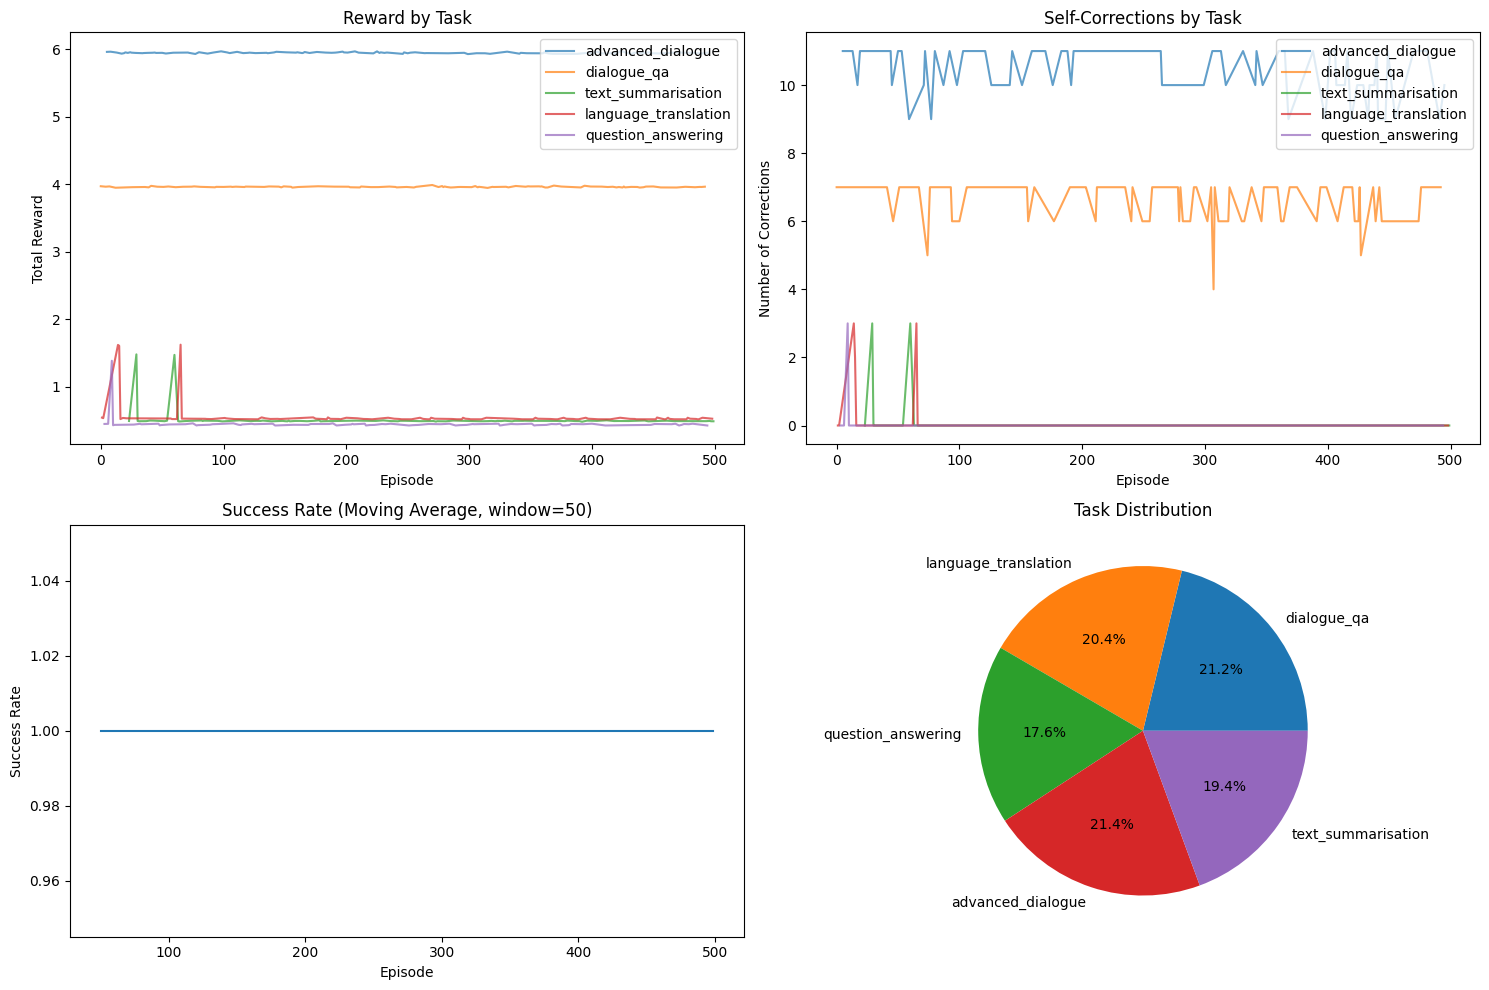

Training completed! Check the log directory for results and analysis.


In [16]:
import torch
import numpy as np
from typing import Dict, List, Any, Optional
import json
from datetime import datetime
import os
from collections import defaultdict

"""
Complete Multi-Task Registration and Training Setup
Shows how to register all NLP environments with the task registry.
"""

from typing import Dict, List, Any, Optional
import torch


def setup_complete_multi_task_training():
    """
    Complete setup for multi-task training with all NLP environments.
    """
    
    print("Setting up Multi-Task NLP Training...")
    
    # Initialise reward ensemble with task-specific models
    reward_ensemble = MultiTaskRewardEnsemble()
    
    # Create and add reward models for each task type
    task_reward_models = {
        'dialogue': TaskRewardModel(task_type='dialogue'),
        'summarisation': TaskRewardModel(task_type='summarisation'),
        'qa': TaskRewardModel(task_type='qa'),
        'translation': TaskRewardModel(task_type='translation'),
        'general': TaskRewardModel(task_type='general')
    }
    
    for task_type, model in task_reward_models.items():
        reward_ensemble.add_reward_model(task_type, model)
        print(f"Added reward model for: {task_type}")
    
    # Initialise the SCARL agent
    agent = SCARLAgent(
        state_dim=256,
        action_dim=10,
        reward_ensemble=reward_ensemble,
        lambda_introspection=0.3,
        r_meta_threshold=0.5,
        learning_rate=1e-4
    )
    
    print("SCARL Agent initialised")
    
    # Setup task registry
    task_registry = NLPTaskRegistry()
    
    # Register all NLP tasks with their configurations and datasets
    
    # Dialogue/Conversational QA
    task_registry.register_task(
        task_name='dialogue_qa',
        task_type='dialogue',
        environment_class=DialogueEnvironment,
        config={
            'max_turns': 8,
            'knowledge_base': {
                "machine learning": "Machine learning enables computers to learn from data without explicit programming.",
                "artificial intelligence": "AI involves creating intelligent machines that can perform human-like tasks.",
                "deep learning": "Deep learning uses neural networks with multiple layers for complex pattern recognition.",
                "natural language processing": "NLP focuses on enabling computers to understand and process human language.",
                "reinforcement learning": "RL involves training agents through rewards and punishments in environments."
            }
        },
        dataset=TaskDataGenerator.generate_dialogue_data(100)  # 100 dialogue examples
    )
    print("Registered: Dialogue QA")
    
    # Text Summarisation
    task_registry.register_task(
        task_name='text_summarisation',
        task_type='summarisation', 
        environment_class=SummarisationEnvironment,
        config={
            'max_summary_length': 150,
            'max_attempts': 3
        },
        dataset=TaskDataGenerator.generate_summarisation_data(100)  # 100 summarisation examples
    )
    print("Registered: Text Summarisation")
    
    # Task 3: Question Answering
    task_registry.register_task(
        task_name='question_answering',
        task_type='qa',
        environment_class=QAEnvironment,
        config={
            'max_depth': 3,
            'context': "Artificial intelligence and machine learning are transforming various industries through automation and intelligent decision-making."
        },
        dataset=TaskDataGenerator.generate_qa_data(100)  # 100 QA examples
    )
    print("Registered: Question Answering")
    
    # Language Translation
    task_registry.register_task(
        task_name='language_translation', 
        task_type='translation',
        environment_class=TranslationEnvironment,
        config={
            'source_language': 'English',
            'target_language': 'Spanish',
            'max_length': 200,
            'max_attempts': 3
        },
        dataset=TaskDataGenerator.generate_translation_data(100)  # 100 translation examples
    )
    print("Registered: Language Translation")
    
    # Advanced Dialogue (more complex)
    task_registry.register_task(
        task_name='advanced_dialogue',
        task_type='dialogue',
        environment_class=DialogueEnvironment,
        config={
            'max_turns': 12,
            'knowledge_base': {
                "quantum computing": "Quantum computing uses quantum-mechanical phenomena to perform computations.",
                "blockchain technology": "Blockchain is a decentralized digital ledger that records transactions securely.",
                "climate change": "Climate change refers to long-term shifts in temperatures and weather patterns.",
                "renewable energy": "Renewable energy comes from natural sources that are constantly replenished.",
                "space exploration": "Space exploration involves discovering celestial structures in outer space."
            }
        },
        dataset=TaskDataGenerator.generate_dialogue_data(50)  # 50 advanced dialogue examples
    )
    print("Registered: Advanced Dialogue")
    
    # 5. Setup task scheduler
    scheduler = MultiTaskScheduler(task_registry)
    
    # 6. Create training coordinator
    coordinator = MultiTaskTrainingCoordinator(
        agent=agent,
        task_registry=task_registry,
        scheduler=scheduler,
        log_dir="multi_task_training_logs"
    )
    
    print("\n" + "="*60)
    print("Multi-Task Setup Complete!")
    print(f"Registered Tasks: {list(task_registry.tasks.keys())}")
    print(f"Total Training Examples: {sum(len(task['dataset']) for task in task_registry.tasks.values())}")
    print("="*60)
    
    return coordinator


def setup_task_specific_training(task_focus: str = "all"):
    """
    Setup training focused on specific task types.
    
    Args:
        task_focus: "all", "dialogue", "summarisation", "qa", "translation"
    """
    
    reward_ensemble = MultiTaskRewardEnsemble()
    agent = SCARLAgent(
        state_dim=256,
        action_dim=10, 
        reward_ensemble=reward_ensemble,
        lambda_introspection=0.3,
        r_meta_threshold=0.5
    )
    
    task_registry = NLPTaskRegistry()
    
    task_configs = {
        'dialogue': {
            'names': ['basic_dialogue', 'technical_dialogue'],
            'count': 150,
            'configs': [
                {'max_turns': 6, 'knowledge_base': {}},
                {'max_turns': 10, 'knowledge_base': {
                    "AI": "Artificial Intelligence", "ML": "Machine Learning"
                }}
            ]
        },
        'summarisation': {
            'names': ['short_summarisation', 'long_summarisation'],
            'count': 120, 
            'configs': [
                {'max_summary_length': 100},
                {'max_summary_length': 200}
            ]
        },
        'qa': {
            'names': ['factual_qa', 'reasoning_qa'],
            'count': 100,
            'configs': [
                {'max_depth': 2},
                {'max_depth': 4}
            ]
        },
        'translation': {
            'names': ['english_spanish', 'english_french'],
            'count': 80,
            'configs': [
                {'source_language': 'English', 'target_language': 'Spanish'},
                {'source_language': 'English', 'target_language': 'French'}
            ]
        }
    }
    
    # Register tasks based on focus
    if task_focus == "all" or task_focus == "dialogue":
        for i, name in enumerate(task_configs['dialogue']['names']):
            task_registry.register_task(
                f"dialogue_{name}",
                'dialogue',
                DialogueEnvironment,
                task_configs['dialogue']['configs'][i],
                TaskDataGenerator.generate_dialogue_data(task_configs['dialogue']['count'] // 2)
            )
    
    if task_focus == "all" or task_focus == "summarisation":
        for i, name in enumerate(task_configs['summarisation']['names']):
            task_registry.register_task(
                f"summarisation_{name}",
                'summarisation',
                SummarisationEnvironment, 
                task_configs['summarisation']['configs'][i],
                TaskDataGenerator.generate_summarisation_data(task_configs['summarisation']['count'] // 2)
            )
    
    if task_focus == "all" or task_focus == "qa":
        for i, name in enumerate(task_configs['qa']['names']):
            task_registry.register_task(
                f"qa_{name}",
                'qa',
                QAEnvironment,
                task_configs['qa']['configs'][i],
                TaskDataGenerator.generate_qa_data(task_configs['qa']['count'] // 2)
            )
    
    if task_focus == "all" or task_focus == "translation":
        for i, name in enumerate(task_configs['translation']['names']):
            task_registry.register_task(
                f"translation_{name}",
                'translation',
                TranslationEnvironment,
                task_configs['translation']['configs'][i],
                TaskDataGenerator.generate_translation_data(task_configs['translation']['count'] // 2)
            )
    
    scheduler = MultiTaskScheduler(task_registry)
    coordinator = MultiTaskTrainingCoordinator(agent, task_registry, scheduler)
    
    print(f"Task-specific setup complete for: {task_focus}")
    print(f"Tasks registered: {list(task_registry.tasks.keys())}")
    
    return coordinator

"""
Multi-Task Training Script for SCARL Framework
Trains the agent on diverse NLP tasks with proper reward models and trajectory collection.
"""

class NLPTaskRegistry:
    """
    Registry for managing multiple NLP tasks and their environments.
    """
    def __init__(self):
        self.tasks = {}
        self.task_statistics = defaultdict(lambda: {
            'episodes_completed': 0,
            'total_reward': 0.0,
            'success_rate': 0.0,
            'avg_corrections': 0.0
        })
    
    def register_task(self, task_name: str, task_type: str, environment_class: Any, 
                     config: Dict[str, Any], dataset: Optional[List] = None):
        """Register a new NLP task."""
        self.tasks[task_name] = {
            'type': task_type,
            'environment_class': environment_class,
            'config': config,
            'dataset': dataset or [],
            'current_dataset_index': 0
        }
    
    def get_environment(self, task_name: str):
        """Get environment instance for a task."""
        if task_name not in self.tasks:
            raise ValueError(f"Task {task_name} not registered")
        
        task_info = self.tasks[task_name]
        env_class = task_info['environment_class']
        config = task_info['config']
        
        # If task has a dataset, use the next example
        if task_info['dataset']:
            dataset = task_info['dataset']
            idx = task_info['current_dataset_index'] % len(dataset)
            config.update(dataset[idx])
            task_info['current_dataset_index'] += 1
        
        return env_class(**config)
    
    def update_statistics(self, task_name: str, episode_stats: Dict[str, Any]):
        """Update task statistics after an episode."""
        stats = self.task_statistics[task_name]
        stats['episodes_completed'] += 1
        stats['total_reward'] += episode_stats['total_r_ext']
        stats['success_rate'] = (
            (stats['success_rate'] * (stats['episodes_completed'] - 1) + 
             episode_stats.get('success', 0)) / stats['episodes_completed']
        )
        stats['avg_corrections'] = (
            (stats['avg_corrections'] * (stats['episodes_completed'] - 1) + 
             episode_stats['num_corrections']) / stats['episodes_completed']
        )

class MultiTaskScheduler:
    """
    Schedules training across multiple NLP tasks with different strategies.
    """
    def __init__(self, task_registry: NLPTaskRegistry):
        self.task_registry = task_registry
        self.task_weights = {task_name: 1.0 for task_name in task_registry.tasks}
        self.task_performance = {}
    
    def get_next_task(self, strategy: str = "round_robin") -> str:
        """Get next task based on scheduling strategy."""
        task_names = list(self.task_registry.tasks.keys())
        
        if strategy == "round_robin":
            # Simple round-robin scheduling
            if not hasattr(self, 'current_task_index'):
                self.current_task_index = 0
            task_name = task_names[self.current_task_index % len(task_names)]
            self.current_task_index += 1
            return task_name
        
        elif strategy == "performance_weighted":
            # Weight tasks by performance (focus on weaker tasks)
            weights = []
            for task_name in task_names:
                perf = self.task_performance.get(task_name, 0.5)
                # Inverse weight: lower performance = higher weight
                weight = 1.0 - perf
                weights.append(max(weight, 0.1))  # Minimum weight
            
            total_weight = sum(weights)
            normalized_weights = [w / total_weight for w in weights]
            return np.random.choice(task_names, p=normalized_weights)
        
        elif strategy == "random":
            return np.random.choice(task_names)
        
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
    
    def update_task_performance(self, task_name: str, success: bool, reward: float):
        """Update performance metrics for a task."""
        if task_name not in self.task_performance:
            self.task_performance[task_name] = 0.5
        
        # Simple moving average of success rate
        current_perf = self.task_performance[task_name]
        new_perf = 0.9 * current_perf + 0.1 * (1.0 if success else 0.0)
        self.task_performance[task_name] = new_perf


class RewardModelTrainer:
    """
    Trains task-specific reward models using human feedback or automated metrics.
    """
    def __init__(self, reward_ensemble: MultiTaskRewardEnsemble):
        self.reward_ensemble = reward_ensemble
    
    def train_reward_model(self, task_type: str, training_data: List[Dict]):
        """
        Train a reward model on human preference data.
        Format: [{'input': str, 'output1': str, 'output2': str, 'preferred': int}]
        """
        if task_type not in self.reward_ensemble.reward_models:
            print(f"Creating new reward model for task: {task_type}")
            self.reward_ensemble.add_reward_model(
                task_type, TaskRewardModel(task_type=task_type)
            )
        
        model = self.reward_ensemble.reward_models[task_type]
        optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)
        criterion = nn.MSELoss()
        
        print(f"Training {task_type} reward model on {len(training_data)} examples...")
        
        for epoch in range(10):  # Small number of epochs for fine-tuning
            total_loss = 0.0
            for batch in self._create_batches(training_data, batch_size=16):
                batch_loss = 0.0
                
                for example in batch:
                    # For preference learning, we want the preferred output to have higher reward
                    preferred_output = example['output1'] if example['preferred'] == 1 else example['output2']
                    dispreferred_output = example['output2'] if example['preferred'] == 1 else example['output1']
                    
                    # Get rewards for both outputs
                    pref_reward = model(example['input'], preferred_output)
                    dispref_reward = model(example['input'], dispreferred_output)
                    
                    # Loss: preferred should be higher than dispreferred by at least margin
                    margin = 1.0
                    loss = torch.relu(dispref_reward - pref_reward + margin)
                    batch_loss += loss
                
                optimiser.zero_grad()
                batch_loss.backward()
                optimiser.step()
                total_loss += batch_loss.item()
            
            if epoch % 2 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(training_data):.4f}")
    
    def _create_batches(self, data: List[Dict], batch_size: int):
        """Create batches from training data."""
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]


class MultiTaskTrainingCoordinator:
    """
    Coordinates training across multiple NLP tasks.
    """
    def __init__(
        self,
        agent: SCARLAgent,
        task_registry: NLPTaskRegistry,
        scheduler: MultiTaskScheduler,
        log_dir: str = "training_logs"
    ):
        self.agent = agent
        self.task_registry = task_registry
        self.scheduler = scheduler
        self.log_dir = log_dir
        self.training_history = []
        
        # Create log directory
        os.makedirs(log_dir, exist_ok=True)
    
    def train(
        self,
        total_episodes: int = 1000,
        episodes_per_task: int = 10,
        meta_train_interval: int = 50,
        save_interval: int = 100,
        scheduling_strategy: str = "round_robin"
    ):
        """Main training loop across multiple tasks."""
        
        print(f"Starting multi-task training for {total_episodes} episodes")
        print(f"Tasks: {list(self.task_registry.tasks.keys())}")
        
        for episode in range(total_episodes):
            # Select task
            task_name = self.scheduler.get_next_task(scheduling_strategy)
            task_info = self.task_registry.tasks[task_name]
            task_type = task_info['type']
            
            # Create environment for the task
            environment = self.task_registry.get_environment(task_name)
            
            # Create trainer and run episode
            trainer = SCARLTrainer(self.agent, environment, task_type=task_type)
            episode_stats = trainer.train_episode(max_steps=100)
            
            # Update statistics
            self.task_registry.update_statistics(task_name, episode_stats)
            self.scheduler.update_task_performance(
                task_name, 
                episode_stats['success'], 
                episode_stats['total_r_ext']
            )
            
            # Log progress
            self.training_history.append({
                'episode': episode,
                'task': task_name,
                'stats': episode_stats
            })
            
            # Print progress
            if episode % 10 == 0:
                self._print_progress(episode, task_name, episode_stats)
            
            # Save checkpoints
            if episode % save_interval == 0 and episode > 0:
                self._save_checkpoint(episode)
        
        # Final save
        self._save_checkpoint(total_episodes)
        print("Multi-task training completed!")
    
    def _print_progress(self, episode: int, task_name: str, stats: Dict[str, Any]):
        """Print training progress."""
        success_symbol = "✓" if stats['success'] else "✗"
        print(f"Episode {episode:4d} | Task: {task_name:15} | "
              f"Reward: {stats['total_r_ext']:6.2f} | "
              f"Corrections: {stats['num_corrections']:2d} | "
              f"Success: {success_symbol} | "
              f"Length: {stats['episode_length']:3d}")
    
    def _save_checkpoint(self, episode: int):
        """Save training checkpoint."""
        checkpoint = {
            'episode': episode,
            'agent_state': {
                'primary_policy': self.agent.primary_policy.state_dict(),
                'corrective_policy': self.agent.corrective_policy.state_dict(),
                'meta_reward_generator': self.agent.meta_reward_generator.state_dict(),
            },
            'training_history': self.training_history,
            'task_statistics': dict(self.task_registry.task_statistics),
            'timestamp': datetime.now().isoformat()
        }
        
        # Save checkpoint
        checkpoint_path = os.path.join(self.log_dir, f"checkpoint_episode_{episode}.pt")
        torch.save(checkpoint, checkpoint_path)
        
        # Save trajectories
        trajectories_path = os.path.join(self.log_dir, f"trajectories_episode_{episode}.json")
        self.agent.trajectory_collector.save_trajectories(trajectories_path)
        
        print(f"Checkpoint saved at episode {episode}")


# Task-specific dataset generators
class TaskDataGenerator:
    """Generates training data for different NLP tasks."""
    
    @staticmethod
    def generate_dialogue_data(num_examples: int = 100) -> List[Dict]:
        """Generate dialogue training examples."""
        dialogues = []
        topics = [
            "machine learning", "python programming", "climate change",
            "health and fitness", "book recommendations", "travel tips"
        ]
        
        for i in range(num_examples):
            topic = topics[i % len(topics)]
            dialogues.append({
                'user_query': f"Can you tell me about {topic}?",
                'knowledge_base': {
                    topic: f"Comprehensive information about {topic} including key concepts and applications."
                }
            })
        
        return dialogues
    
    @staticmethod
    def generate_summarisation_data(num_examples: int = 100) -> List[Dict]:
        """Generate summarisation training examples."""
        summaries = []
        topics = [
            "artificial intelligence", "renewable energy", "space exploration",
            "quantum computing", "biotechnology", "sustainable agriculture"
        ]
        
        for i in range(num_examples):
            topic = topics[i % len(topics)]
            source_text = f"""
            {topic.capitalize()} has been a rapidly evolving field in recent years. 
            Researchers have made significant breakthroughs that are transforming industries 
            and society. The key developments include improved algorithms, better hardware, 
            and more practical applications. Future directions point toward even more 
            sophisticated systems that can solve complex real-world problems.
            """
            summaries.append({
                'source_text': source_text,
                'max_summary_length': 100
            })
        
        return summaries
    
    @staticmethod
    def generate_qa_data(num_examples: int = 100) -> List[Dict]:
        """Generate question-answering training examples."""
        qa_pairs = []
        questions = [
            "What is the capital of France?",
            "How does photosynthesis work?",
            "What are the benefits of exercise?",
            "Explain the theory of relativity",
            "What is blockchain technology?",
            "How do neural networks learn?"
        ]
        
        for i in range(num_examples):
            question = questions[i % len(questions)]
            qa_pairs.append({
                'question': question,
                'context': f"Answer the question: {question}"
            })
        
        return qa_pairs
    
    @staticmethod
    def generate_translation_data(num_examples: int = 100) -> List[Dict]:
        """Generate translation training examples."""
        translations = []
        sentences = [
            "Hello, how are you today?",
            "The weather is beautiful today.",
            "I enjoy learning new things.",
            "Technology is transforming our world.",
            "Science helps us understand nature."
        ]
        
        for i in range(num_examples):
            sentence = sentences[i % len(sentences)]
            translations.append({
                'source_text': sentence,
                'target_language': "Spanish",
                'source_language': "English"
            })
        
        return translations

# Updated training script
def run_training():
    """Run training"""
    print("Starting Multi-Task Training...")
    
    # Setup and train
    coordinator = setup_complete_multi_task_training()
    
    coordinator.train(
        total_episodes=500,  # Smaller for testing
        episodes_per_task=5,
        meta_train_interval=25,
        save_interval=50,
        scheduling_strategy="random"
    )
    
    print("Training completed successfully!")


def analyse_training_results(log_dir: str):
    """Analyse and visualise training results."""
    import matplotlib.pyplot as plt
    
    # Load training history
    checkpoint_files = [f for f in os.listdir(log_dir) if f.startswith('checkpoint')]
    latest_checkpoint = max(checkpoint_files)
    checkpoint_path = os.path.join(log_dir, latest_checkpoint)
    
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    history = checkpoint['training_history']
    
    # Plot learning curves
    tasks = set([entry['task'] for entry in history])
    
    plt.figure(figsize=(15, 10))
    
    # Plot rewards by task
    plt.subplot(2, 2, 1)
    for task in tasks:
        task_rewards = [entry['stats']['total_r_ext'] for entry in history if entry['task'] == task]
        episodes = [entry['episode'] for entry in history if entry['task'] == task]
        plt.plot(episodes, task_rewards, label=task, alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward by Task')
    plt.legend()
    
    # Plot corrections by task
    plt.subplot(2, 2, 2)
    for task in tasks:
        task_corrections = [entry['stats']['num_corrections'] for entry in history if entry['task'] == task]
        episodes = [entry['episode'] for entry in history if entry['task'] == task]
        plt.plot(episodes, task_corrections, label=task, alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Number of Corrections')
    plt.title('Self-Corrections by Task')
    plt.legend()
    
    # Plot success rates
    plt.subplot(2, 2, 3)
    success_rates = []
    window_size = 50
    for i in range(window_size, len(history)):
        recent = history[i-window_size:i]
        success_rate = sum(1 for entry in recent if entry['stats']['success']) / window_size
        success_rates.append(success_rate)
    
    plt.plot(range(window_size, len(history)), success_rates)
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.title(f'Success Rate (Moving Average, window={window_size})')
    
    # Plot task distribution
    plt.subplot(2, 2, 4)
    task_counts = {}
    for entry in history:
        task = entry['task']
        task_counts[task] = task_counts.get(task, 0) + 1
    
    plt.pie(task_counts.values(), labels=task_counts.keys(), autopct='%1.1f%%')
    plt.title('Task Distribution')
    
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir, 'training_analysis.png'))
    plt.show()

def demonstrate_task_execution():
    """
    Demonstrate how tasks are executed through the registry.
    """
    print("\n" + "="*60)
    print("Demonstrating Task Execution")
    print("="*60)
    
    # Setup a small registry for demonstration
    task_registry = NLPTaskRegistry()
    
    # Register a few example tasks
    task_registry.register_task(
        'demo_dialogue',
        'dialogue',
        DialogueEnvironment,
        {
            'user_query': "What is artificial intelligence?",
            'knowledge_base': {
                "artificial intelligence": "AI involves creating machines that can think and learn like humans."
            },
            'max_turns': 3
        },
        dataset=[]  # No dataset for demo
    )
    
    task_registry.register_task(
        'demo_summarisation',
        'summarisation',
        SummarisationEnvironment,
        {
            'source_text': "Machine learning algorithms can identify patterns in data and make predictions based on those patterns.",
            'max_summary_length': 50
        },
        dataset=[]
    )
    
    # Demonstrate task execution
    print("1. Executing Dialogue Task:")
    dialogue_env = task_registry.get_environment('demo_dialogue')
    state = dialogue_env.reset()
    print(f"   Initial state: {state.context_text}")
    
    # Simulate an action
    action = Action(
        action_type=ActionType.PRIMARY,
        content="Artificial intelligence is a field of computer science focused on creating machines that can perform tasks requiring human intelligence."
    )
    
    next_state, reward, done, info = dialogue_env.step(action)
    print(f"   Agent response: {info.get('response', '')}")
    print(f"   Reward: {reward:.3f}")
    print(f"   Done: {done}")
    
    print("\n2. Executing Summarisation Task:")
    summ_env = task_registry.get_environment('demo_summarisation')
    state = summ_env.reset()
    print(f"   Source text: {state.context_text[:100]}...")
    
    action = Action(
        action_type=ActionType.PRIMARY,
        content="ML algorithms find patterns in data to make predictions."
    )
    
    next_state, reward, done, info = summ_env.step(action)
    print(f"   Summary: {info.get('summary', '')}")
    print(f"   Reward: {reward:.3f}")
    print(f"   Done: {done}")

# Main execution
if __name__ == "__main__":

    demonstrate_task_execution()
    
    print("=" * 60)
    print("Multi-Task NLP Training for SCARL Framework")
    print("=" * 60)
    
    # Training
    run_training()
    
    # Analyse results
    analyse_training_results(coordinator.log_dir)
    
    print("Training completed! Check the log directory for results and analysis.")